
# Compressed Sensing
## Single pixel imaging strategies : A survey of old and new methods

Authors: Alexandre Marquis, Me

## Bibliography :
This work is based on the following articles : 


1.   Liheng Bian, Jinli Suo, Qionghai Dai, and Feng Chen. Experimental comparison of single-pixel imaging
algorithms. Journal of the Optical Society of America A, 2018.
2.   Marco F. Duarte, Mark A. Davenport, Dharmpal Takhar, Jason N. Laska, Ting Sun, Kevin F. Kelly, and Richard G. Baraniuk. Single-Pixel Imaging via
Compressive Sampling : Building simpler, smaller, and less-expensive digital cameras.  IEEE Signal Processing Magazine, 2008.
3. Ruoyang Yao, Marien Ochoa, Pingkun Yan and Xavier Intes. Net-FLICS: fast quantitative wide-field fluorescence lifetime imaging with compressed sensing – a deep learning approach. Light: Science & Applications, 2019.



# Part I: Introduction

Single pixel imaging, henceforth SPI, is a novel imaging technique that produces 2D images from a single photodiode instead of a conventional 2D array of sensors. This allows for a great simplification in the architecture of cameras thus greatly reducing costs. The authors of [2] propose their own design of a single pixel camera and proved that it performs better than conventional DMD (digital micromirror device) cameras. Following [1], SPI modulates light patterns using either a diffuser or a  programmable light modulator. The correlated light is then collected by a photodiode and the original 2D image can be reconstructed from the modulation patterns and the 1D measurements using various algorithms. SPI has been applied in a plethora of fields ranging from object tracking to optical encryption.

In this project, we review a wide range of SPI techniques and compare their performance in various settings. We begin by presenting the algorithms, we then compare their performance with respect to the reconstructed image size and the noise level in terms of reconstruction power and the time taken. We end by presenting a novel technique based on a deep learning approach taken from [3].

# Part II : SPI algorithms

In this part we present the various SPI techniques.

We start by importing the necessary packages 

In [37]:
%matplotlib inline
!pip install gdown
import numpy as np
from matplotlib import pyplot as plt
import imageio
from math import *
from skimage import color
from skimage.transform import resize
from scipy.optimize import line_search
from scipy.linalg import hadamard
import itertools


## Non iterative methods : 
 
We present here some non iterative SPI methods. 

### Basis scan : 
Let $n$ denote the number pixels in the target 2D scene. The basis scan algorithm takes $n$ light measurements  from different combinations of the pixels using test functions from a general basis. Following 2, we chose the Walsh basis and the Hadamard basis. The Walsh basis was modified to include $0$ instead of $-1$. Let $W$ denote the basis matrix and $y$ the measurement vector, then the 2d scene, $x$ can be reconstructed as such : $x = W^{-1} y$.

The Hadamard matrix can be construced recursively by initialising the matrices of order 2 and 4, one can then use $H(2^K) = H(2) \bigotimes H(2^{k-1})$ where $H(2^k)$ denotes the Hadamard matrix of order $2^k$ and $\bigotimes$ is the Kronecker product. The Walsh matrix can then be constructed from a Hadamard matrix of a comparable size after reordering rows according to the sign change count. The sign change count is defined as the number of sign changes in a given row iterating sequentially. For example, $[-1, 1, -1]$ has a sign change count of $2$. 

The below three functions implement this algorithm. 

N.B : Walsh matrix generation takes a lot of space so trying a size 128 would not work.

In [38]:
def sign_change(row):
    """Implements the sign change count in a given matrix row
    
    Inputs : 
        row : A 1D array-like 
    Outputs : 
        The count of sign change
    """
    return len(list(itertools.groupby(row, lambda row: row > 0))) - (row[0] > 0)

In [39]:
def walsh_mat(n):
    """Implements walsh matrix 
    Inputs :
        n : The squared root size of the walsh matrix
    Outputs : 
        Walsh matrix of size n**2
    """
    hadamard_mat = hadamard(n**2)
    idx = [sign_change(hadamard_mat[j, :]) for j in range(hadamard_mat.shape[0])]
    return  hadamard_mat[idx, :]

In [40]:
def basis_scan(img, basis='Hadamard'):
    """ Simulates a basis scan algorithm 
    
    Inputs : 
        img : The image to bereconstructed
        
    Outputs :
        A flattened version of the reconstructed image
    """
    if basis=='Hadamard':
        print('Computing Hadamard matrix')
        pttrn_mat = hadamard(img.shape[0]**2)
    elif basis=='Walsh':
        print('Computing Walsh matrix')
        pttrn_mat = walsh_mat(img.shape[0])
    else:
        print('Basis can be either Hadamard or Walsh, terminating reconstruction')
        return None
    print('Reconstruction...')
    x = pttrn_mat@img.reshape(-1, 1)
    return np.linalg.solve(pttrn_mat, x)

### Correlation modulation method :
Following [1], let $A \in \mathbb{R}^{m\times n}$ denote the light modulation matrix ($m$ denote the number of modulation patterns and $n$ is the pixel count) and $b \in \mathbb{R}^{m\times 1}$ be the measurement vector. We also denote by $x$ the target scene where $x \in \mathbb{R}^{n\times 1}$. Usually, $m \neq n$ which implies that $A$ is not symmetric. This can be overcomed via a multiplication by $A^T$ thus giving the equation : $A^TA x = A^T b$ which can be solved easily in most cases. However, when $m < n$ the matrix $A^T A$ is not of full rank and this technique would not work. 

Using the fact that SPI measures the correlation between the modulation patterns and the target scene, we can reconstruct the image by correlating the measurment patterns with the modulation patterns with the measurements values. The reconstructed scene is then given by : $x = \{b_i\textbf{a}_i\} - \{b_i\}\{\textbf{a}_i\}$ where $b_i$ denotes the $i$-th measurement, $\textbf{a}_i$ is $i$-th row in the modulation matrix and $\{.\}$ denotes the mean operator. 

In [41]:
def correlation_modulation_method(A, b):
    """ Implements correlation moduation single pixel reconstruction
    
    Inputs : 
        A: Measurements matrix
        b: Measuremets vector
        
    outputs :
        A flattened version of the image
    """
    return np.mean(np.multiply(A,b), axis=0) - np.mean(b) * np.mean(A, axis=0)

### Differential Ghost Imaging (DGI) method : 

The DGI method was proposed as an improvement to the previous one. What sets the two methods apart is that in the DGI method,  we take into account the illumination fluctuations and we measure the intensity of  each illumination pattern. If we denote by $S \in \mathbb{R}^{m\times 1}$ the vector of illumination patterns intensities then the DGI reconstruction is given by the following formula : $x = \{b_i\textbf{a}_i\} - \frac{\{b_i\}}{\{s_i\}} \{s_i\textbf{a}_i\}$

In [42]:
def DGI(pttrn_mat, b):
    """ Implements Differential ghost imaging single pixel reconstruction
    
    Inputs : 
        pttrn_mat: Patterns matrix
        b: Measuremets vector
         
    outputs : 
        The reconstructed image
    """
    as_mean, ab_mean = 0, 0
    for i in range(pttrn_mat.shape[2]):
        pttrn = pttrn_mat[:, :, i]
        ab_mean = (ab_mean * i + pttrn * b[i])/(i+1)
        as_mean = (as_mean * i + np.sum(pttrn)*pttrn)/(i+1)
    return ab_mean - np.mean(b)/np.mean(np.sum(pttrn_mat, axis =2)) * as_mean

## Iterative methods 

### Gradient descent algorithm 

One can formulate the SPI problem as a minimisation problem where the goal is to reduce the error between the real measurements and the estimated ones. This minilisation problem can be written in the form of a quadratic minimisation problem : $ \min_x L(x) = \min_x\|Ax-b\|_2^2$. 

The gradient of this function can be easily derived : $\nabla L(x) = 2A^T(Ax-b)$. The gradient descent algorithm consist in repeating the following operation: $ x = x - \gamma_x \nabla L(x)$ where $\gamma_x$ denotes the step size. The authors of [1] proved that the optimal step size is given by : $\gamma_x =  \frac{\nabla L(x) A^T (Ax-b)}{\nabla L(x) A^T A \nabla L(x)}$.  The following function implements this algorithm.

In [11]:
def GD(A, b, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements gradient descent algorithm
    
    Inputs : 
        A : Measurements matrix
        b : Measurements vector
        max_iter : The maximum number of iterations
        tol : The tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        A flattened version of the reconstructed image (a vector)
    """
    x =  np.zeros((A.shape[1], 1)) # initial guess
    r, eps, i = b - A@x, 1, 0 #residual and the threshold (set to 1 just for initialisation)
    while(i<=max_iter and eps>tol):
        grad = -2*A.T@r # gradient computation 
        step = -grad.T@A.T@r/(grad.T@A.T@A@grad) # Optimal step
        x -= step*grad # gradient descent step 
        eps, r = r, b - A@x # updating the residual
        eps = np.abs(np.linalg.norm(eps) - np.linalg.norm(r)) # Computing the threshold
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))
        i += 1
    return (x-np.min(x))/(np.max(x)-np.min(x))

### Conjugate gradient descent 

The conjugate gradient descent method solves the same minimisation problem as the gradient descent but it requires that the $A$ be symmetric and positive. The trick is to use a multiplication of a factor of $A^T$ to get the following equation : $A^TAx = A^Tb \rightarrow A^{'}x = b^{'}$. Let $r^k = b^{'} - A^{'} x^k$ denote the residual error vector at iteration $k$
then the gradient at iteration $k$ is given by : $\nabla L(x^k) = -r^{(k-1)} - \frac{{r^{(k-1)}}^T r^{(k-1)}}{{r^{(k-2)}}^T r^{(k-2)}} \nabla L(x^{(k-1)})$. The optimal step size is obtained using the following formula : $\gamma_x^k = \frac{{r^{(k-1)}}^T r^{(k-1)}}{{\nabla L(x^k)}^T A^{'} \nabla L(x^k)}$. Theoretically, the conjugate gradient descent should converge in no more than $n$ steps to the reconstructed scene.


In [12]:
def CGD(A, b, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements conjugate gradient descent algorithm
      
    Inputs : 
        A : Measurements matrix
        b : Measurements vector
        max_iter : The maximum number of iterations
        tol : the tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        A flattened version of the reconstructed image (a vector)
    """
    x, A, b =  np.ones((A.shape[1], 1)), A.T@A, A.T@b # initial guess and input transformation
    r, i= b - A@x, 0
    r_prev, grad, eps = r, r, np.linalg.norm(r)
    while(i<=max_iter and eps>tol):
        i += 1
        step = r.T@r / (grad.T@A@grad) # Optimal step computation
        x += step*grad #gradient descent step (inversed sign in the step explains the +)
        r = b - A@x # residual computation
        grad = r + (r.T@r/(r_prev.T@r_prev))*grad # gradient computation 
        eps = np.abs(np.linalg.norm(r)-np.linalg.norm(r_prev)) 
        r_prev = r
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))
    return (x-np.min(x))/(np.max(x)-np.min(x))

### Poisson maximum likelihood method 

Adapting from [1] and using the assumption that photons arrive at the sensor following a Poisson distribution, we can reconstruct the 2D scene by estimating a vector $x$ that maximises the likelihood of obtaining the measurements vector $b$. The maximum likelihood problem of the Poisson distribution is given by : $ \max_x \prod\limits_i^m \frac{\mathrm{e}^{\textbf{a}_ix}(\textbf{a}_ix)^{b_i}}{b_i !}$. This is equivalent to solving $\min_x \sum\limits_i^m (\textbf{a}_ix - b_i\log(\textbf{a}_ix))$. Again, we can use the gradient descent algorithm to solve this problem. The gradient in this case is given by : $ \nabla L(x) = \frac{A^T(Ax-b)}{Ax}$. The optimal step size is however determined using a backtracking line search algorithm.

In [13]:
def obj_func(x, A, b):
    """ Implements the opposite of the log likelihood of the Poisson distribution
    
    Inputs : 
        x : The points where the objective function is to be computed
        A : The measurements matrix
        b : The measurements vector
        
    outputs : 
        The value of the function 
    """
    eps = np.finfo(np.float32).eps # used for the log to avoid log(0)
    return np.sum(A@x-b*np.log(np.abs(A@x + eps))) # absolute value is added for to avoid errors in the log

In [14]:
def back_track(x, A, b, obj_func, grad, alpha=0.1, beta=0.5):
    """ Implements the bach track line search algorithm for optimal step size search
    
    Inputs : 
        x : The points where the objective function is to be computed
        A : The measurements matrix
        b : The measurements vector
        obj_func : The objective function needed for the algorithm
        grad : the computed grad at point x
        alpha, beta : parameters for the back track algorithm set by the user
                         tune them to control the speed
    outputs : 
        The optimal step size
    """
    assert (0<= alpha <=1) and (0<= beta <= 1) # Assert that both values are between 0 an 1
    temp = x / grad  # keep the step not so large, so that x>0, trick taken frm the author of 1
    temp = np.where(temp<0, 1, temp)
    step = min(1, np.min(temp)) # initial step size
    while obj_func(x - step*grad, A,b) > (obj_func(x, A, b) - alpha*step*grad.T@grad):
        step *= beta # decrease the step
    return step

In [31]:
def Poisson_mle(A, b, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements the Poisson maximum likelihood single pixel reconstruction
    
     Inputs : 
        A : measurements matrix
        b : measurements vector
        max_iter : The maximum number of iterations
        tol : the tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        A flattened version of the reconstructed image (a vector)
    """
    x =  np.ones((A.shape[1], 1)) # initial guess 
    r, i, eps = b - A@x, 0, 1 
    while(i<=max_iter and eps>tol):
        grad = A.T@(1 - b / A@x) # grdaient computation
        #search for optimal step size
        step = back_track(x, A, b, obj_func, grad)
        x -= step*grad # gradient descent step
        eps, r = r, b - A@x
        eps = np.abs(np.linalg.norm(r)-np.linalg.norm(eps))
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))
        i += 1
    return x

### Alternating projection method 

The alternating projection method for SPI is adapted from the same method for phase retrieval. The method considers the reconstruction from a spectrum point of view. Without going into greater details, the AP updates the reconstructed scene iteratively using the following formula : $x = x - \frac{\textbf{a}_i^T\bigodot(\textbf{a}_i^T\bigodot x)}{\max(\textbf{a}_i)^2}\frac{\textbf{a}_ix- b_i}{\textbf{a}_ix}$. It uses all the measurements sequentially to update the scene.

In [16]:
def alternate_projection(pttrn_mat, measurements, max_iter=10000, tol=1e-6, verbose=True):
    """ Implements the alternate projection algorithm for single pixel reconstruction
    
     Inputs : 
        pttrn_mat  : Patterns matrix
        b : Measurements vector
        max_iter : The maximum number of iterations
        tol : The tolerance of needed for the convergence to be reached
        verbose : A flag for printing the threshold and the iterations count
        
    Outputs : 
        The reconstructed image
    """
    rows, cols, lyrs = pttrn_mat.shape
    img_rcnst, i, eps = np.ones((rows, cols)), 0, 1 # initialisation 
    rows, cols, lyrs = pttrn_mat.shape # to compute the measurement matrix, for error evaluation
    A = pttrn_mat.reshape(rows*cols, lyrs).T
    r = measurements - A@img_rcnst.flatten()
    while(i<=max_iter and eps>tol) :
        for j in range(lyrs):
            aux = img_rcnst*pttrn_mat[:, :, j]
            temp = aux
            aux = aux - np.mean(aux) + measurements[j] / np.size(aux)
            img_rcnst = np.abs(img_rcnst + pttrn_mat[:, :, j] / np.max(pttrn_mat[:, :, j])**2 * (aux - temp))
        eps, r = r, measurements - A@img_rcnst.flatten()
        eps = np.abs(np.linalg.norm(r) - np.linalg.norm(eps))
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))  
        i+= 1
    return (img_rcnst-np.min(img_rcnst))/(np.max(img_rcnst) - np.min(img_rcnst))

## Non linear iterative methods 


In this section we present two compressed sensing algorithms for SPI. The first is the Sparse Representation prior and the Total Variation regularisation prior. The first states that natural images are sparse when represented using an overcomplete or an orthogonal basis, such as DCT basis, while the second uses the fact that the gradient's integral is statistically low. We present the augmented lagrange multiplier algorithm which can be used for both priors as the only thing that changes from one prior to another is the basis matrix.

Let $D$ and $c$ denote the basis transform matrix and the coefficients vector respectively. The optimisation model is given by : 
$$ \min \|c\|_{l_0} $$
s.t. 
$$ Dx = c$$
and 
$$ AX = b$$.

Using the $l_1$ norm to approximate the $l_0$ one, for easier reconstruction, one can solve the above problem using a gradient descent method after employing the augmented lagrange multiplier which is a fast and robust method for $l_1$ minimisaton. We introduce a lagrange multiplier $y$ that incorporates the equality constraints into the objective function. Rearranging terms, the problem can be written as : $\min \|c\|_{l_1} + \frac{\mu_1}{2}\|Dx-c+\frac{y_1}{\mu_1}\|_{l_2}^2 + \frac{\mu_2}{2}\|Ax-b+\frac{y_2}{\mu_2}\|_{l_2}^2  $ where $\mu_{\{1, 2\}}$ are for balancing different optimisation terms. The variableq in this optimisation problem are the following : $x, c, y_1, y_2, \mu_1$ and $\mu_2$. Using the iterative updating scheme of the ALM method, the updating procedure for the different variables is as follows :


1.   Optimise $c$: $c = \mathbb{T}_{\frac{1}{\mu_1}}(Dx\frac{y_1}{\mu_1})$ where $\mathbb{T}_{\frac{1}{\mu_1}}$ is a threshold operator given by :
$$
(\mathbb{T}_{\frac{1}{\mu_1}}(x)): 
 \left\{
 \begin{array}{lll}
 x - \frac{1}{mu_1}, \text{ if } x > \frac{1}{\mu_1}
 \\
 x + \frac{1}{mu_1}, \text{ if } x < -\frac{1}{\mu_1}
 \\
0, \text{ otherwise.}
 \end{array}
 \right .
$$
2.   Optmise $x$: $x = (\mu_1 D^TD + \mu_2 A^TA)^{-1} [\mu_1 D^T(c-\frac{y_1}{\mu_1}) + \mu_2 A^T(b - \frac{y_2}{\mu_2})]$
3. Optimise $y$ and $\mu$ : 
$$ y_1 = y1 + \mu_1(Dx-c)$$
$$ y_2 = y2 + \mu_2(Ax -b) $$
$$  \mu_1 = \min(\rho \mu_1, \mu_{1max}) $$
$$ \mu_2 = \min(\rho \mu_2, \mu_{2max}) $$ 
Where $\rho$ and $\mu_{max}$ are parameters set by the user to adjust the growing speed of $y$ and $\mu$.

The algorithm described above is used for both priors and we only change $D$ in the implementation : DCT for Sparse representation and gradient operator matrix for Total Variation prior. For the gradient operator, we implemented the operator matrix only to the 2nd order.


In [17]:
def dct_basis(rows, cols):
    """Implments DCT basis generation 

    Inputs : 
        rows : The number of rows
        cols : The number of columns
        
    Outputs : 
        The DCT basis matrix of size rows*cols squared
    """
    assert rows>0 and cols>0
    sz = rows*cols # The size of a single dimension of the matrix
    x = np.tile(np.arange(rows), cols) 
    y = np.zeros((sz, 1))
    for idx in range(cols):
        y[idx*rows+1:idx*rows+rows] = idx
    DCT_mat, idx = np.zeros((sz, sz)), 0 #initialisation
    for i in range(rows):
        for j in range(cols):
            ai, aj = sqrt(2/rows), sqrt(2/cols)
            if i == 0:
                ai = 1/sqrt(rows)
            if j == 0:
                aj = 1/sqrt(cols)
            DCT_mat[idx] = ai * aj * np.multiply(np.cos(pi*(2*x+1)*i/(2*rows)), np.cos(pi*(2*y+1)*j/(2*cols)).ravel())
            idx += 1
    return DCT_mat 

In [18]:
def grad_op(rows, cols):
    """ Implements the gradient operator matrix up to order 2

    Inputs :
      rows : The number of rows
      cols : The number of cols

    Outputs : 
      the gradient operator matrix of 
    """
    grad_1, grad_2 = [1, -1], [1, -2, 1] # first and second derivatives in the x and y directions
    grad_xy =[-1, 1, 1, -1] # cross derivative (df^2/dxy)
    
    #storing matrices H1 to H5 for all the derivatives 
    # gradient operator matrix in x direction
    temp = np.zeros(((rows*(cols-1), rows*cols)))
    for i in range(rows):
        for j in range(cols-1):
            temp[i+j*rows, i+j*rows],  temp[i+j*rows, i+(j+1)*rows] = grad_1[0], grad_1[1]       
    G = temp
    
    # Gradient operator matrix for the y direction 
    temp = np.zeros(((cols*(rows-1), rows*cols)))
    for i in range(rows-1):
        for j in range(cols):
            temp[i+j*(rows-1), i+j*rows],  temp[i+j*(rows-1), i+1+j*rows] = grad_1[0], grad_1[1]
    G = np.vstack((G, temp))
    
    # Grdient operator matrix for x^2 derivation 
    temp = np.zeros((rows*(cols-2),rows*cols))
    for i in range(rows):
        for j in range(cols-2):
            temp[i+j*rows, i+j*rows] = grad_2[0]
            temp[i+j*rows, i+(j+1)*rows] = grad_2[1]
            temp[i+j*rows,i+(j+2)*rows] = grad_2[2]
    G = np.vstack((G, temp))
    
    # Grdient operator matrix for y^2 derivation 
    temp = np.zeros(((rows-2)*cols, rows*cols))
    for i in range(rows-2):
        for j in range(cols):
            temp[i+j*(rows-2), i+j*rows] = grad_2[0]
            temp[i+j*(rows-2), i+1+j*rows] = grad_2[1]
            temp[i+j*(rows-2),i+2+j*rows] = grad_2[2] 
    G = np.vstack((G, temp))

    # Grdient operator matrix for xy derivation  
    temp = np.zeros(((rows-1)*(cols-1), rows*cols))
    for i in range(rows-1):
        for j in range(cols-1):
            temp[i+j*(rows-1), i+j*rows] = grad_xy[0]
            temp[i+j*(rows-1), i+1+j*rows] = grad_xy[1]
            temp[i+j*(rows-1),i+(j+1)*rows] = grad_xy[2] 
            temp[i+j*(rows-1),i+1+(j+1)*rows] = grad_xy[2] 
    G = np.vstack((G, temp))
    
    return G

In [19]:
def NLM(A, b, rows, cols, method='DCT', rho=0.7, mu_max=(5, 5), max_iter=10000, tol=1e-6, verbose=True):
    if method == 'DCT':
        print("Computing DCT basis matrix")
        S = dct_basis(rows, cols)
    elif method == 'grad_img':
        print("Computing 2nd order Gradient operator")
        S = grad_op(rows, cols)
    else:
        print("Prior can be one of grad_img or DCT, terminating reconstruction...")
        return None
    x, i, eps = np.ones((A.shape[1], 1)), 0, 1
    mu, y1, y2 = np.ones((2,1)), np.ones((S.shape[0], 1)), np.ones_like(b)
    r = b - A@x
    while(i<=max_iter and eps>tol):
        c = S@x + y1/mu[0]
        c = np.where(c-1/mu[0],
                    c>1/mu[0],
                    np.where(c+1/mu[0], c<-1/mu[0], 0))
        x = np.linalg.solve(mu[0]*S.T@S + mu[1]*A.T@A, 
                            mu[0]*S.T@(c-y1/mu[0]) + mu[1]*A.T@(b-y2/mu[1]))
        y1 += mu[0]*(S@x - c)
        y2 += mu[1]*(A@x - b)
        mu[0], mu[1] = min(rho*mu[0], mu_max[0]), min(rho*mu[1], mu_max[1])
        eps, r = r,  b - A@x
        eps = np.abs(np.linalg.norm(eps) - np.linalg.norm(r))
        if  verbose and i%10==0:
            print("Iteration number {} out of {}, the error is {}".format(i, max_iter, eps))  
        i += 1
    return (x-np.min(x))/(np.max(x)-np.min(x))

The function below computes the RMSE between the original scene and the reconstructed one.

In [43]:
def RMSE(img_og, img_reconst):
    """ Implements the root mean squared error
    Inputs :
      img_or : original image
      img_reconst : reconstructed image
    
    Outputs : 
      The RMSE value
    """
    err = np.linalg.norm(img_og-img_reconst)/np.sqrt(img_reconst.size)
    return err/np.mean(img_og)

## QUANTITATIVE COMPARISON

We will now test our algorithms and their reconstruction power. We will work with pictures of size 64*64 for ease of computation. We will compare the different algorithms performance with respect to the sampling ratio and the noise level. Then we will investigate the performance with respect to the image size.

### First test : 
We will run our algorithms and see how they perform on a test image.



In [62]:
# Global parameters needed for the reconstruction algs
pxl_cnt = 64 # pixel count in each dimension of the image
smpl_ratio = 1 #sampling ratio

Original Grey-level image data shape :  (317, 475)
Resized Grey-level image data shape :  (64, 64)


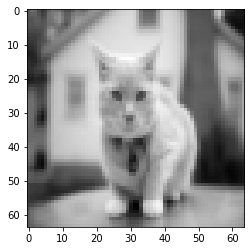

In [63]:
# Reading an input image
file_name = './images/cat.png' # select the image name
img_in = imageio.imread(file_name)# Read the image
img_gray = color.rgb2gray(img_in) # converting to gray scale
print('Original Grey-level image data shape : ', img_gray.shape) # the original shape of the image
img_rsz = resize(img_gray, (pxl_cnt, pxl_cnt), order=1,
                 preserve_range=True, anti_aliasing=True) # Resiwing to the desired size
print('Resized Grey-level image data shape : ', img_rsz.shape) # the original shape of the image
plt.imshow(img_rsz,cmap='gray');

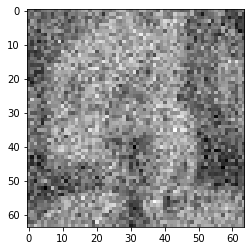

In [55]:
plt.imshow(DGI(pttrn_mat, measurements).reshape(pxl_cnt, pxl_cnt), cmap='gray')

In [64]:
pttrn_cnt = round(smpl_ratio*pxl_cnt**2) #The number of illumination patterns
pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                              size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
# Computing the measurements
measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
measurements = measurements.reshape(-1, 1)
# Initialisation
rows, cols, lyrs = pttrn_mat.shape
A = pttrn_mat.reshape(rows*cols, lyrs).T

In [65]:
measurements.shape

(4096, 1)

Reconstructing using the correlation modulation method. 

Reconstructed image : 


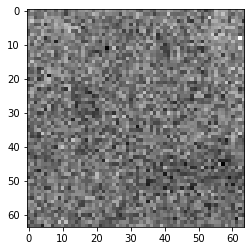

In [47]:
# SPI correlation modulation reconstruction 
print('Reconstructing using the correlation modulation method. \n');
res = correlation_modulation_method(A, measurements).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');

Reconstructing using the DGI method. 

Reconstructed image : 


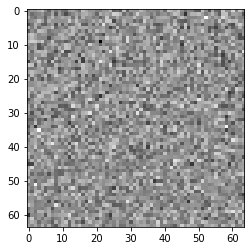

In [48]:
# SPI Differential ghost imaging reconstruction
print('Reconstructing using the DGI method. \n');
res = DGI(pttrn_mat, measurements)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');

Reconstructing using the GD method. 

Iteration number 0 out of 10000, the error is 67663.54511759884
Iteration number 10 out of 10000, the error is 0.023540272747283097
Iteration number 20 out of 10000, the error is 0.02340119955962905
Iteration number 30 out of 10000, the error is 0.023263313793592033
Iteration number 40 out of 10000, the error is 0.023126604830949304
Iteration number 50 out of 10000, the error is 0.022991062132092566
Iteration number 60 out of 10000, the error is 0.022856675233370538
Iteration number 70 out of 10000, the error is 0.022723433756453915
Iteration number 80 out of 10000, the error is 0.022591327408960638
Iteration number 90 out of 10000, the error is 0.022460345965470196
Iteration number 100 out of 10000, the error is 0.022330479288058314
Iteration number 110 out of 10000, the error is 0.02220171732238896
Iteration number 120 out of 10000, the error is 0.02207405007645491
Iteration number 130 out of 10000, the error is 0.021947467655479613
Iteration num

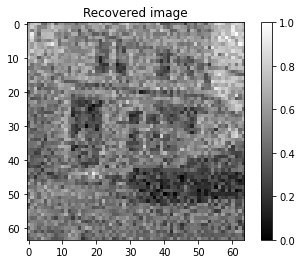

In [79]:
# SPI gradient descent (GD) reconstruction
print('Reconstructing using the GD method. \n');
res = GD(A, measurements, max_iter=10000, tol=1e-2).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');
plt.axis('on')
plt.title('Recovered image')
plt.colorbar()
plt.show()

Reconstructing using the CGD method. 

Iteration number 10 out of 10000, the error is 100.43781596744842
Iteration number 20 out of 10000, the error is 5.015509693580412
Iteration number 30 out of 10000, the error is 990.7790910840397
Iteration number 40 out of 10000, the error is 479.3939266356515
Iteration number 50 out of 10000, the error is 7.825462407040646
Iteration number 60 out of 10000, the error is 0.21557719338885484
Iteration number 70 out of 10000, the error is 0.23201101285265935
Iteration number 80 out of 10000, the error is 0.299698036428814
Iteration number 90 out of 10000, the error is 150.7335375406457
Iteration number 100 out of 10000, the error is 4.196715559191875
Iteration number 110 out of 10000, the error is 4.8432954026148405
Iteration number 120 out of 10000, the error is 5.756206317180972
Iteration number 130 out of 10000, the error is 8.883817894551134
Iteration number 140 out of 10000, the error is 16.022752349650606
Iteration number 150 out of 10000, the 

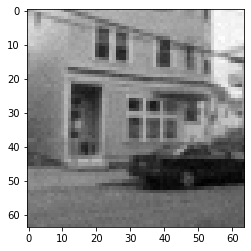

In [80]:
# SPI conjugate gradient descent (CGD) reconstruction
print('Reconstructing using the CGD method. \n');
res = CGD(A, measurements, max_iter=10000, tol=1e-3).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');

Reconstructing using the Poisson maximum likelihood estimation method. 

Iteration number 0 out of 30, the error is 0.0
Reconstructed image : 


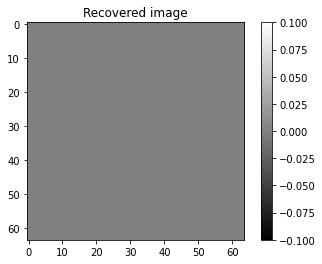

In [81]:
# SPI Poisson maximum likelihood estimation reconstruction
print('Reconstructing using the Poisson maximum likelihood estimation method. \n');
res = Poisson_mle(A, measurements, max_iter=30, tol=1e-6).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');
plt.axis('on')
plt.title('Recovered image')
plt.colorbar()
plt.show()

Reconstructing using the Alternating Projection method 

Iteration number 0 out of 100, the error is 3985748.768774154
Iteration number 10 out of 100, the error is 51.49027992373885
Iteration number 20 out of 100, the error is 17.125901542720385
Iteration number 30 out of 100, the error is 6.956204884867475
Iteration number 40 out of 100, the error is 3.2742979541581008
Iteration number 50 out of 100, the error is 1.6202117548964452
Iteration number 60 out of 100, the error is 0.7373971657143557
Iteration number 70 out of 100, the error is 0.21488122134906007
Reconstructed image : 


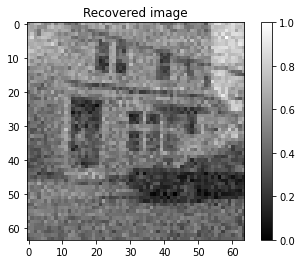

In [82]:
###### SPI Alternating Projection reconstruction
print('Reconstructing using the Alternating Projection method \n');
res = alternate_projection(pttrn_mat, measurements, max_iter=100, tol=1e-2)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');
plt.axis('on')
plt.title('Recovered image')
plt.colorbar()
plt.show()

Reconstructing using the Sparse representation prior method. 

Computing DCT basis matrix
Iteration number 0 out of 100, the error is 63115.05720875172
Iteration number 10 out of 100, the error is 0.006630415940399814
Reconstructed image : 


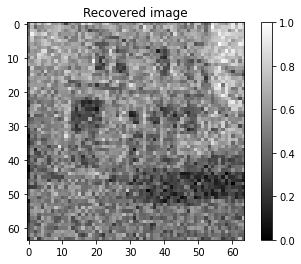

In [83]:
# SPI Sparse representation prior reconstruction
print('Reconstructing using the Sparse representation prior method. \n');
res = NLM(A, measurements, rows, cols, method='DCT', max_iter=100, tol=1e-2).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');
plt.axis('on')
plt.title('Recovered image')
plt.colorbar()
plt.show()

Reconstructing using the Sparse representation prior method. 

Computing 2nd order Gradient operator
Iteration number 0 out of 100, the error is 63115.641636103304
Reconstructed image : 


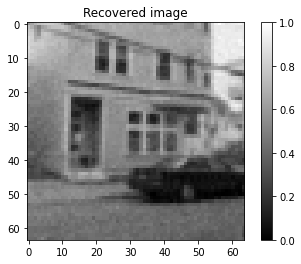

In [85]:
# SPI Total variation prior reconstruction
print('Reconstructing using the Sparse representation prior method. \n');
res = NLM(A, measurements, rows, cols, method='grad_img',  max_iter=100, tol=1e-2).reshape(pxl_cnt, pxl_cnt)
print('Reconstructed image : ') 
plt.imshow(res,cmap='gray');
plt.axis('on')
plt.title('Recovered image')
plt.colorbar()
plt.show()

From this first inspection, we can see that, visually speaking :


1.   The best results were achieved by the CGD method.
2.   The Poisson maximum likelihood method performs the worst and from our experience the results won't improve so we will exclude it from the analysis.
3.   The correlation modulation and the DGI method perform similarly even though the latter should be an improvement of the former.
4.   The alternate projection method is slow to converge and it needs a big number of iteration to produce satisfactory results.
5.   The Total variation prior performs better than the Sparse representation one and produces results comparable to the CGD one albeit being slower.
6.   The basis scan method wasn't tested as it will perfectly reconstruct the scene (the reader can check).

  


### Sampling ration and reconstruction error

Following [1], we will choose several values for the sampling ratio ranging from 0.5 to 5 and inspect the reconstruction error for every method. For each method and for each sampling ratio, we plot the reconstructed scene. The results can be seen below.

In [54]:
smpl_ratio_rg = np.arange(0.5, 5, 0.5) # the sampling ratios used 
pttrn_mat_l , A_l, measurements_l, rows_l, cols_l= [], [], [], [], []
for i in range(smpl_ratio_rg.size):
    pttrn_cnt = round(smpl_ratio_rg[i]*pxl_cnt**2) #The number of illumination patterns
    pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                                size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
    # Computing the measurements
    measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
    measurements = measurements.reshape(-1, 1)
    # Initialisation
    rows, cols, lyrs = pttrn_mat.shape
    A = pttrn_mat.reshape(rows*cols, lyrs).T
    A_l.append(A)
    rows_l.append(rows)
    cols_l.append(cols)
    measurements_l.append(measurements)
    pttrn_mat_l.append(pttrn_mat)

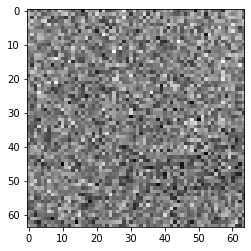

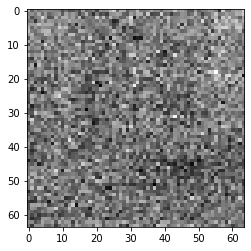

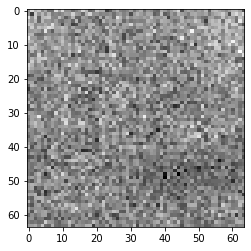

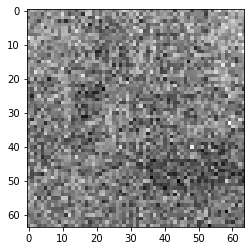

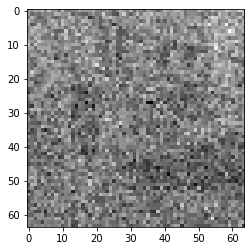

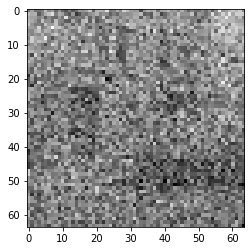

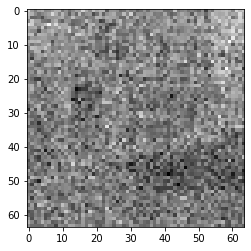

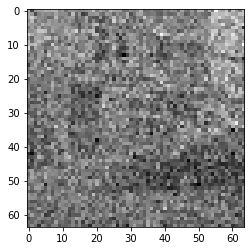

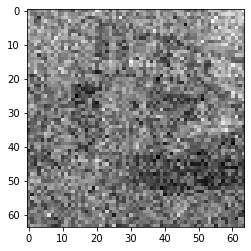

In [50]:
error_mc = []
for i in range(smpl_ratio_rg.size):
    res = correlation_modulation_method(A_l[i], measurements_l[i]).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_mc.append(RMSE(img_rsz, res))

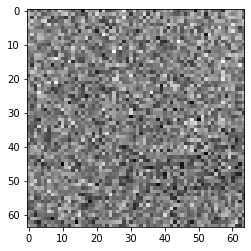

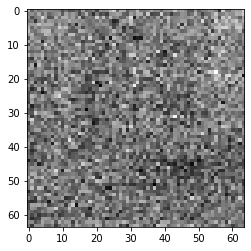

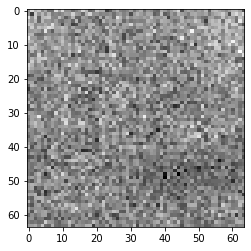

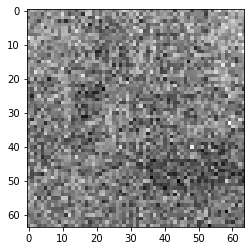

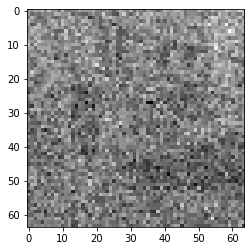

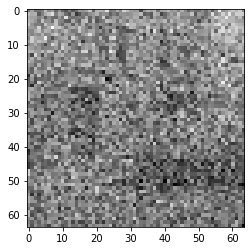

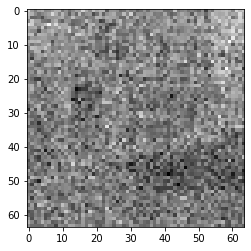

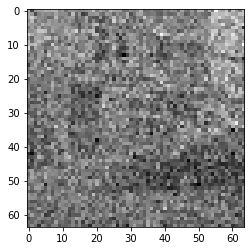

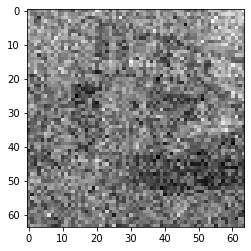

In [51]:
error_dgi = []
for i in range(smpl_ratio_rg.size):
    res = DGI(pttrn_mat_l[i], measurements_l[i])
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_dgi.append(RMSE(img_rsz, res))

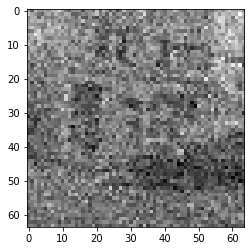

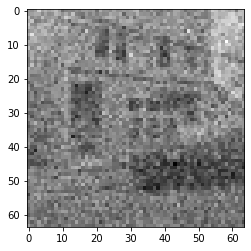

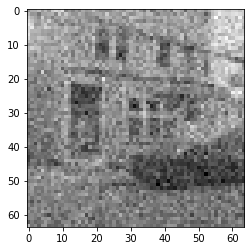

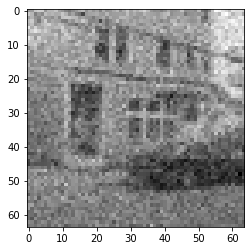

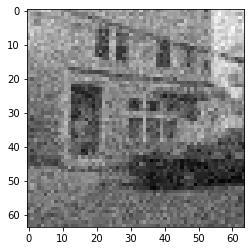

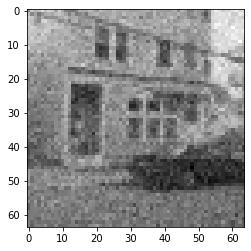

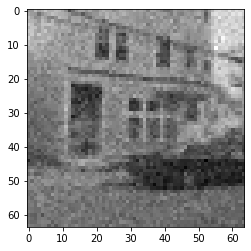

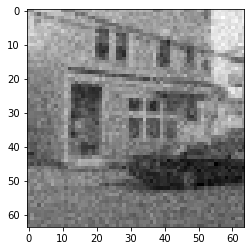

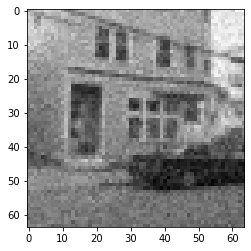

In [52]:
error_gd = []
for i in range(smpl_ratio_rg.size):
    res = GD(A_l[i], measurements_l[i], tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_gd.append(RMSE(img_rsz, res))

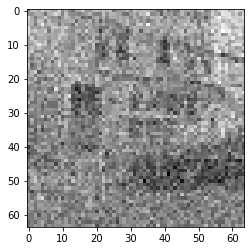

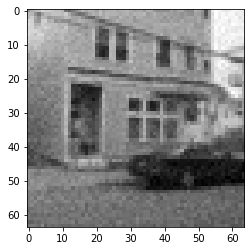

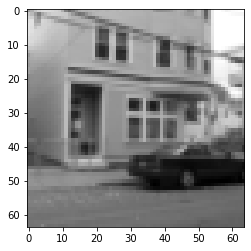

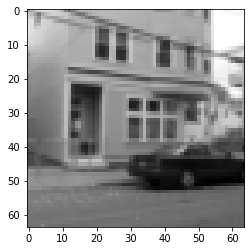

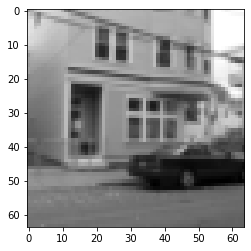

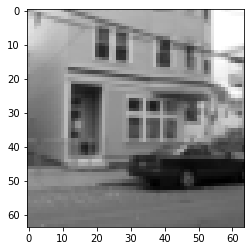

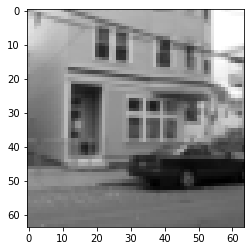

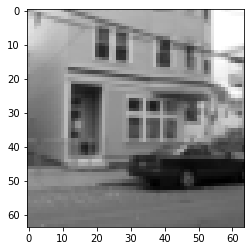

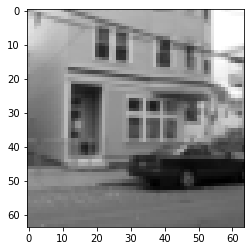

In [24]:
error_cgd = []
for i in range(smpl_ratio_rg.size):
    res = CGD(A_l[i], measurements_l[i], tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_cgd.append(RMSE(img_rsz, res))

Reconstruction iteration 0
Reconstruction iteration 1
Reconstruction iteration 2
Reconstruction iteration 3
Reconstruction iteration 4
Reconstruction iteration 5
Reconstruction iteration 6
Reconstruction iteration 7
Reconstruction iteration 8


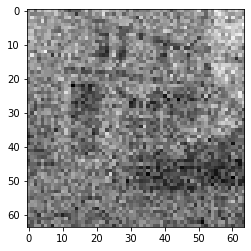

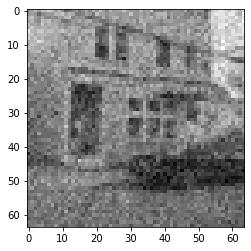

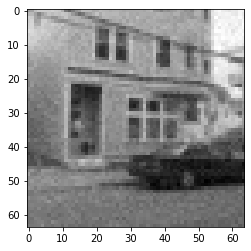

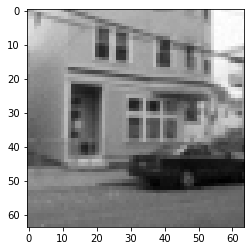

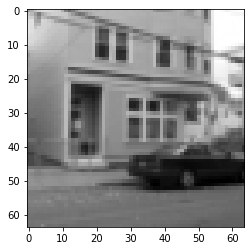

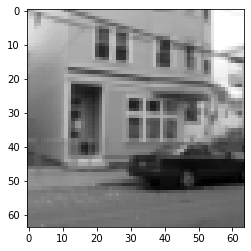

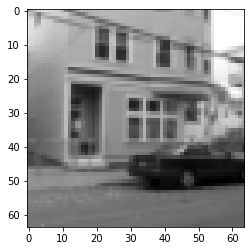

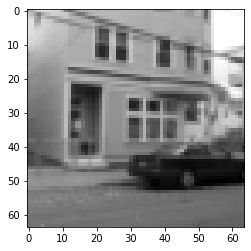

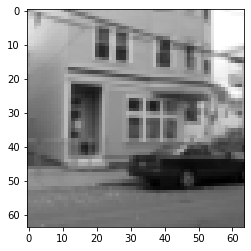

In [67]:
error_ap = []
for i in range(smpl_ratio_rg.size):
    print("Reconstruction iteration", i)
    res = alternate_projection(pttrn_mat_l[i], measurements_l[i], max_iter=100, tol=1e-2, verbose=False)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_ap.append(RMSE(img_rsz, res))  

Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix


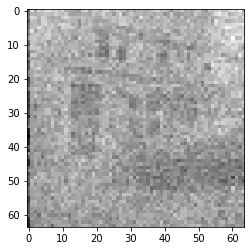

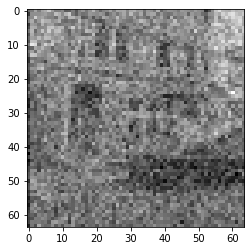

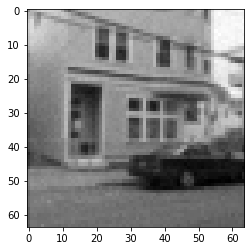

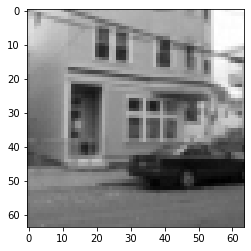

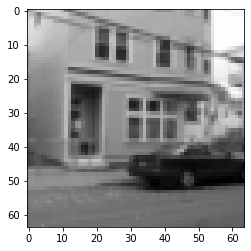

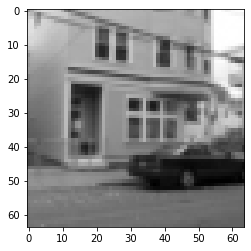

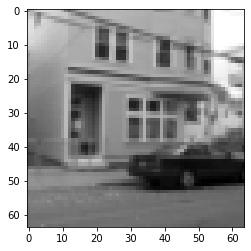

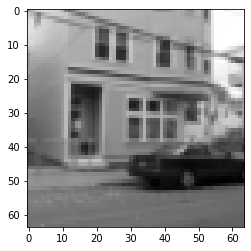

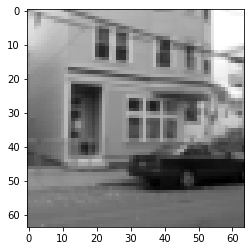

In [62]:
error_sr = []
for i in range(smpl_ratio_rg.size):
    res = NLM(A_l[i], measurements_l[i], rows_l[i], cols_l[i], method='DCT', max_iter=1000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_sr.append(RMSE(img_rsz, res))

Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator


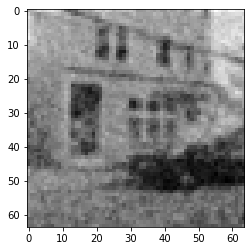

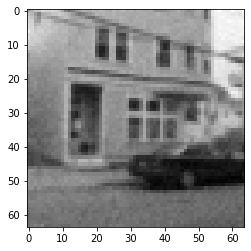

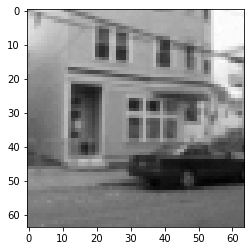

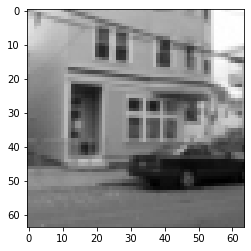

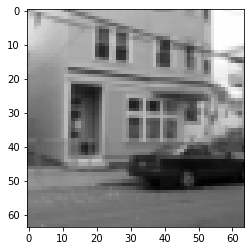

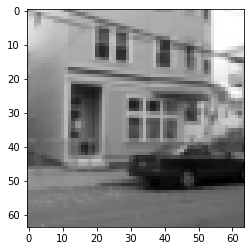

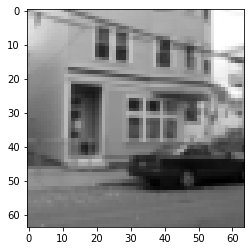

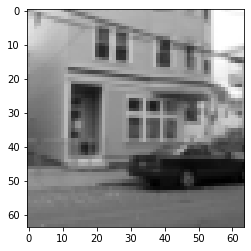

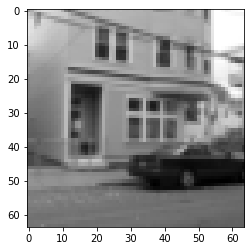

In [65]:
error_tv = []
for i in range(smpl_ratio_rg.size):
    res = NLM(A_l[i], measurements_l[i], rows_l[i], cols_l[i], method='grad_img', max_iter=1000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_tv.append(RMSE(img_rsz, res))

#### Plotting the results

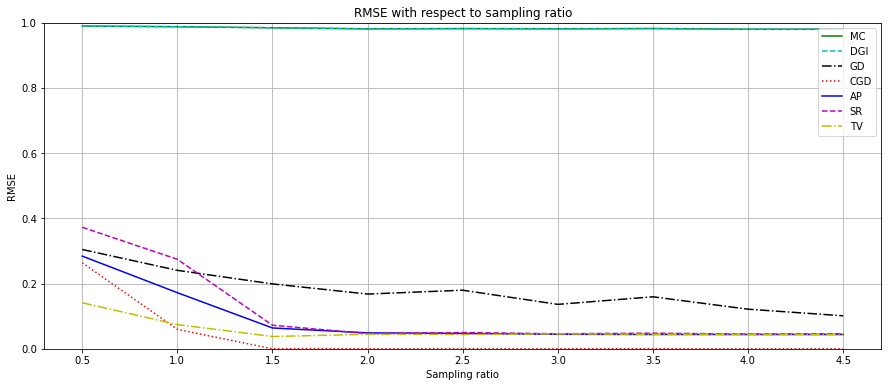

In [74]:
plt.figure(figsize=(15,6))
plt.plot(smpl_ratio_rg, error_mc, '-g', label='MC')  # solid green
plt.plot(smpl_ratio_rg, error_dgi, '--c', label='DGI') # dashed cyan
plt.plot(smpl_ratio_rg, error_gd, '-.k', label='GD') # dashdot black
plt.plot(smpl_ratio_rg, error_cgd, ':r', label='CGD');  # dotted red
plt.plot(smpl_ratio_rg, error_ap, '-b', label='AP')  # solid green
plt.plot(smpl_ratio_rg, error_sr, '--m', label='SR') # dashed cyan
plt.plot(smpl_ratio_rg, error_tv, '-.y', label='TV') # dashdot black
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="upper right")
plt.title('RMSE with respect to sampling ratio');
plt.xlabel('Sampling ratio')
plt.ylabel('RMSE');

We can see that as the sampling ratio increases, the quality of the reconstruction gets better for all the algorithms except for the modulation correlation and the differential ghost imaging algorithms.


1.   We noticed that the fastest and the algorithm that returned the best results was the CGD.
2.   The compressed sensing algorithms and the alternating projection method performed well and are not far behind the CGD method although they are a lot slower to converge and need more computation power.
3.  The gradient descent method also achieved satisfactory results but only with a high sampling ratio. It is also worth noting that it doesn't scale well and was the slowest method overall.


  

### Image size influence

We will consider images of sizes : 32, 64, 96, 128 for our analysis with a constant sampling ratio of 1. We will then compare the reconstruction error of the various methods.

In [75]:
img_sz_l = [32, 64, 96, 128]
smpl_ratio = 1
pttrn_mat_l, img_rsz_l, A_l, measurements_l, rows_l, cols_l = [], [], [], [], [], []
for pxl_cnt in img_sz_l:
    img_rsz = resize(img_gray, (pxl_cnt, pxl_cnt), order=1,
                 preserve_range=True, anti_aliasing=True) # Resizing to the desired size
    pttrn_cnt = round(smpl_ratio*pxl_cnt**2) #The number of illumination patterns
    pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                              size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
    # Computing the measurements
    measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
    measurements = measurements.reshape(-1, 1)
    # Initialisation
    rows, cols, lyrs = pttrn_mat.shape
    A = pttrn_mat.reshape(rows*cols, lyrs).T
    img_rsz_l.append(img_rsz)
    pttrn_mat_l.append(pttrn_mat)
    A_l.append(A)
    measurements_l.append(measurements)
    rows_l.append(rows)
    cols_l.append(cols)

In [76]:
error_mc = []
for i, pxl_cnt in enumerate(img_sz_l):
    res = correlation_modulation_method(A_l[i], measurements_l[i]).reshape(pxl_cnt, pxl_cnt)
    error_mc.append(RMSE(img_rsz_l[i], res))

In [78]:
error_dgi = []
for i, pxl_cnt in enumerate(img_sz_l):
    res = DGI(pttrn_mat_l[i], measurements_l[i])
    error_dgi.append(RMSE(img_rsz_l[i], res))

In [90]:
error_gd = []
for i, pxl_cnt in enumerate(img_sz_l):
    print("Reconstruction iteration ", i)
    res = GD(A_l[i], measurements_l[i], max_iter=1000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    error_gd.append(RMSE(img_rsz_l[i], res))

Reconstruction iteration  0
Reconstruction iteration  1
Reconstruction iteration  2
Reconstruction iteration  3


In [82]:
error_cgd = []
for i, pxl_cnt in enumerate(img_sz_l):
    print("Reconstruction iteration ", i)
    res = CGD(A_l[i], measurements_l[i], max_iter=10000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    error_cgd.append(RMSE(img_rsz_l[i], res))

Reconstruction iteration  0
Reconstruction iteration  1
Reconstruction iteration  2
Reconstruction iteration  3


In [83]:
error_ap = []
for i, pxl_cnt in enumerate(img_sz_l):
    print("Reconstruction iteration ", i)
    res = alternate_projection(pttrn_mat_l[i], measurements_l[i], max_iter=100, tol=1e-2, verbose=False)
    error_ap.append(RMSE(img_rsz_l[i], res))  

Reconstruction iteration  0
Reconstruction iteration  1
Reconstruction iteration  2
Reconstruction iteration  3


In [93]:
error_sr = []
for i, pxl_cnt in enumerate(img_sz_l):
    print("Reconstruction iteration ", i)
    res = NLM(A_l[i], measurements_l[i], rows_l[i], cols_l[i], method='DCT', max_iter=10, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    error_sr.append(RMSE(img_rsz_l[i], res))

Reconstruction iteration  0
Computing DCT basis matrix
Reconstruction iteration  1
Computing DCT basis matrix
Reconstruction iteration  2
Computing DCT basis matrix
Reconstruction iteration  3
Computing DCT basis matrix


In [95]:
error_tv = []
for i, pxl_cnt in enumerate(img_sz_l):
    print("Reconstruction iteration ", i)
    res = NLM(A_l[i], measurements_l[i], rows_l[i], cols_l[i], method='grad_img', max_iter=10, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    error_tv.append(RMSE(img_rsz_l[i], res))

Reconstruction iteration  0
Computing 2nd order Gradient operator
Reconstruction iteration  1
Computing 2nd order Gradient operator
Reconstruction iteration  2
Computing 2nd order Gradient operator
Reconstruction iteration  3
Computing 2nd order Gradient operator


KeyboardInterrupt: 

#### Plotting the results

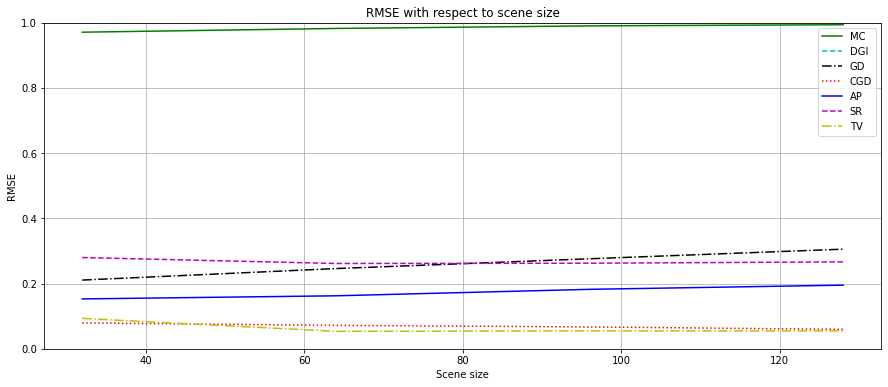

In [99]:
plt.figure(figsize=(15,6))
plt.plot(img_sz_l, error_mc, '-g', label='MC')  # solid green
plt.plot(img_sz_l, error_dgi, '--c', label='DGI') # dashed cyan
plt.plot(img_sz_l, error_gd, '-.k', label='GD') # dashdot black
plt.plot(img_sz_l, error_cgd, ':r', label='CGD');  # dotted red
plt.plot(img_sz_l, error_ap, '-b', label='AP')  # solid green
plt.plot(img_sz_l, error_sr, '--m', label='SR') # dashed cyan
plt.plot(img_sz_l, error_tv, '-.y', label='TV') # dashdot black
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="upper right")
plt.title('RMSE with respect to scene size');
plt.xlabel('Scene size')
plt.ylabel('RMSE');

From the plot above we can see that as the image size increases, the construction error increases for most of the methods except for the conjugate gradient descent and the Total Variation method which seem to stabilise or decrease. However, the Total variation method is incredibly slow and in practise unusable.


1.  The conjugate gradient descent is the fastest method overall and the one that achieved the best results.
2. The compressed sensing methods, the gradient descent and the alternating projection algorithm don't have a good scale property as they take more time to converge as the image size increases. Unless the implementation is improved these method aren't viable for a high definition image reconstruction. For example, for a size of 129*128 scene, the Total Variaton algorithm takes more than 3 hours for 10 iterations.

### Noise level influence

Adapting from [1], we will add Gaussian noise to the measurements vector and observe how the construction error is affected. We will use the ratio between the standard deviation and the pixel count to generate the noise. We will consider 3 ratio : $1e-4$, $5e-4$ and $3e-3$. It is worth noting that we take an image size of $64*64$ and sampling ratio of 1. We will plot the results for each method and noise level.

In [100]:
noise_ratio = [1e-4, 5e-4, 3e-3]
smpl_ratio = 1
pxl_cnt = 64
img_rsz = resize(img_gray, (pxl_cnt, pxl_cnt), order=1,
             preserve_range=True, anti_aliasing=True) # Resizing to the desired size
pttrn_cnt = round(smpl_ratio*pxl_cnt**2) #The number of illumination patterns
pttrn_mat =  np.random.uniform(low=0.0, high=1.0,
                          size=(pxl_cnt, pxl_cnt, pttrn_cnt)) # Computing the patters, uniform distribution
# Computing the measurements
measurements = np.sum(np.sum(np.multiply(np.tile(img_rsz[:, :, np.newaxis], [1, 1, pttrn_cnt]), pttrn_mat), axis=0), axis=0)
measurements = measurements.reshape(-1, 1)
# Initialisation
rows, cols, lyrs = pttrn_mat.shape
A = pttrn_mat.reshape(rows*cols, lyrs).T

In [103]:
measurements_l = []
for ratio in noise_ratio:
    noise = ratio*pxl_cnt**2*np.random.randn(measurements.shape[0], measurements.shape[1])
    measurements_l.append(noise+measurements)

Reconstruction iteration  3
Reconstruction iteration  3
Reconstruction iteration  3


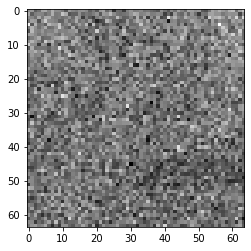

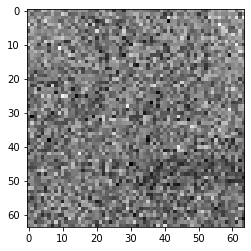

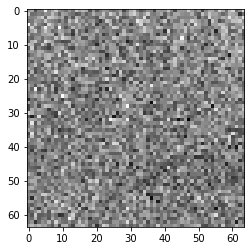

In [104]:
error_mc = []
for measurement in measurements_l:
    print("Reconstruction iteration ", i)
    res = correlation_modulation_method(A, measurement).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_mc.append(RMSE(img_rsz, res))

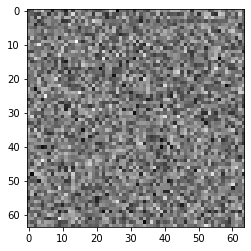

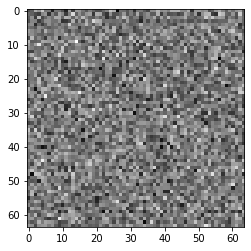

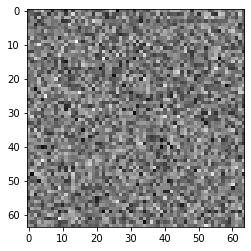

In [105]:
error_dgi = []
for measurement in measurements_l:
    res = DGI(pttrn_mat, measurement)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_dgi.append(RMSE(img_rsz, res))

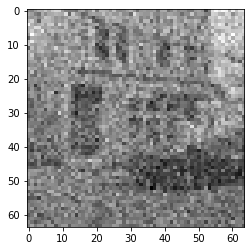

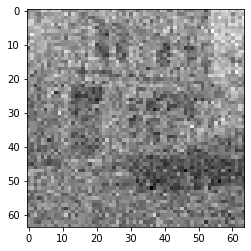

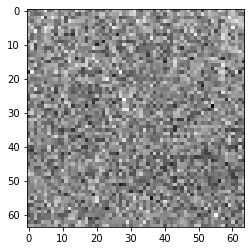

In [106]:
error_gd = []
for measurement in measurements_l:
    res = GD(A, measurement, max_iter=10000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_gd.append(RMSE(img_rsz, res))

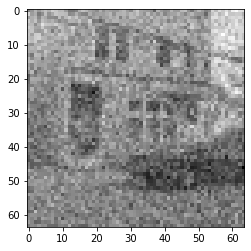

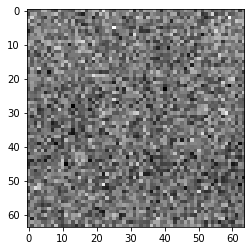

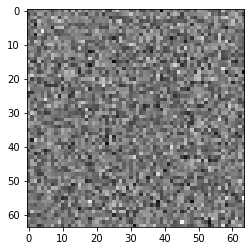

In [107]:
error_cgd = []
for measurement in measurements_l:
    res = CGD(A, measurement, max_iter=10000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_cgd.append(RMSE(img_rsz, res))

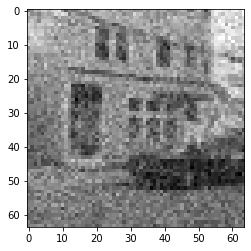

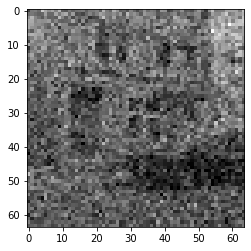

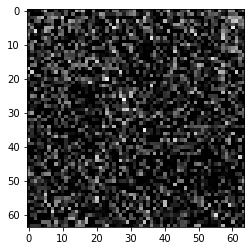

In [108]:
error_ap = []
for measurement in measurements_l:
    res = alternate_projection(pttrn_mat, measurement, max_iter=100, tol=1e-2, verbose=False)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_ap.append(RMSE(img_rsz, res))  

Computing DCT basis matrix
Computing DCT basis matrix
Computing DCT basis matrix


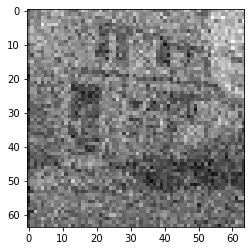

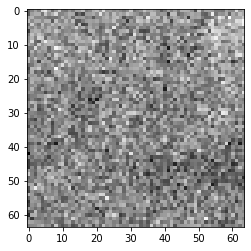

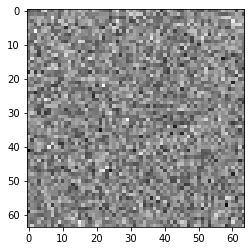

In [109]:
error_sr = []
for measurement in measurements_l:
    res = NLM(A, measurement, rows, cols, method='DCT', max_iter=1000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_sr.append(RMSE(img_rsz, res))

Computing 2nd order Gradient operator
Computing 2nd order Gradient operator
Computing 2nd order Gradient operator


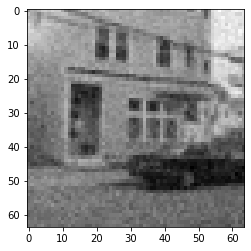

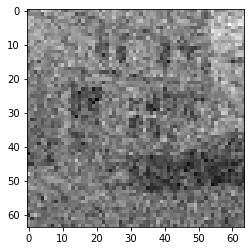

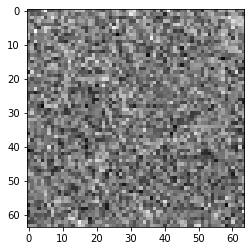

In [111]:
error_tv = []
for measurement in measurements_l:
    res = NLM(A, measurement, rows, cols, method='grad_img', max_iter=1000, tol=1e-2, verbose=False).reshape(pxl_cnt, pxl_cnt)
    plt.figure() 
    plt.imshow(res,cmap='gray');
    error_tv.append(RMSE(img_rsz, res))

#### Plotting the results

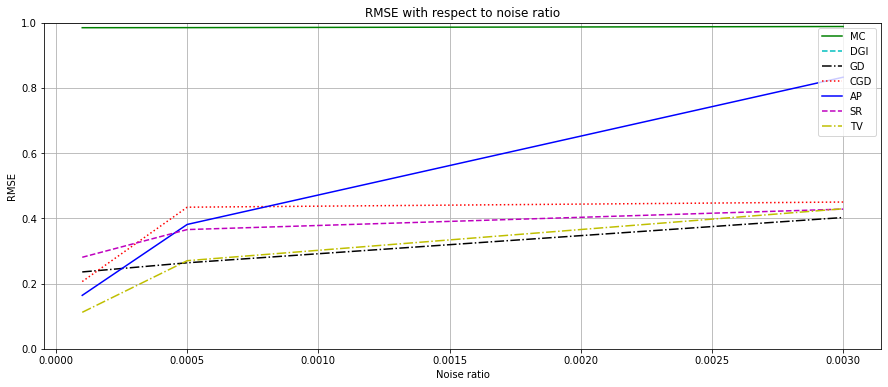

In [112]:
plt.figure(figsize=(15,6))
plt.plot(noise_ratio, error_mc, '-g', label='MC')  # solid green
plt.plot(noise_ratio, error_dgi, '--c', label='DGI') # dashed cyan
plt.plot(noise_ratio, error_gd, '-.k', label='GD') # dashdot black
plt.plot(noise_ratio, error_cgd, ':r', label='CGD');  # dotted red
plt.plot(noise_ratio, error_ap, '-b', label='AP')  # solid green
plt.plot(noise_ratio, error_sr, '--m', label='SR') # dashed cyan
plt.plot(noise_ratio, error_tv, '-.y', label='TV') # dashdot black
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="upper right")
plt.title('RMSE with respect to noise ratio');
plt.xlabel('Noise ratio')
plt.ylabel('RMSE');

As we can notice, the reconstructed scene quality degrades with the noise ratio. We can see that this is true for all methods. 

1. Surprisingly, the gradient descent algorithm seems to perform better than the conjugate version considering that the latter outperformed the former in the previous experiments.
2. The compressed sensing methods outperformed the conjugate gradient descent and they seem more robust to noise increase than the gradient descent algorithm. This confirms the claim of the authors of [1] about the methods' robustness with regards to the noise. 

## Conclusion

In this part, we have tested various SPI algorithm for reconstructing scenes under different circumstances. The modulation correlation and the differential ghost imaging methods performed the worst in every setting so we conclude that they can't be reliably used for SPI applications. When it comes to scalability, the conjugate gradient descent algorithm is the best and yields excellent results. However, in a noisy measurements setting, which is the case in the real world,it performs poorly. The compressed sensing methods seem to perform better in the aferomentioned situation however they do not scale well and they are usually slow to converge. One can consider some speed up for these algorithms as an extension of this work to make these algorithms viable for a high definition SPI reconstruction (well above the $128*128$ pixel for our tests).

# Application : Macroscopic fluorescence lifetime imaging

## Introduction
We are now going to talk about an application of Compressed Sensing which is the Macroscopic Fluorescence Lifetime Imaging. We will more specifically talk about the Deep Learning approach that was proposed by Ruoyang Yao, Marien Ochoa, Pingkun Yan and Xavier Intes from the Rensselaer Polytechnic Institute (their paper can be found here : https://www.nature.com/articles/s41377-019-0138-x).

## Fluorescence Lifetime Imaging
Fluorescence Lifetime Imaging is a method consisting in measuring the time delay between the excitation of a fluorophore and its fluorescent response. In practice, the fluorophore molecule absorbs a photon which in return leads to an excitation from the ground state into a higher energetic state. As nature always prefer lower energy states, the molecule will then return to its original state by going though intermediate states by releasing photons (which is the fluorescent response).
<figure>
    <img src="https://www.researchgate.net/publication/51792045/figure/fig1/AS:214094524227585@1428055520190/Schematic-of-states-and-transitions-for-a-fluorophore-in-which-the-dark-state-is-the.png"
         >
    <figcaption>Schematic of states and transitions for a fluorophore in which the dark state is the default state and bleaching occurs from the activated state.</figcaption>
</figure>
Those transitions do not last long, the molecule is usually back in its original state in a matter of some nanoseconds. The electron decay depend on a lot of parameters, but is mostly sensible to the molecules that surround the fluorophore molecule and is independant of its concentration, this implies that the time needed for the molecule to return to its initial state will characterise the molecules that surround it. This technique allows us to precisely identify those molecules. It is mostly used to detect brain tumors (which contains Nicotinamide Adenine Dinucleotides, easily identifiable with this method).

<figure>
    <img src="https://marculab.bme.ucdavis.edu/files/2014/08/flimgbm.jpg"
         alt="Elephant at sunset">
    <figcaption>FLIM image of (left) Normal Brain (cortex) and (right) tumor (high grade glioma) infiltrated in brain cortex.</figcaption>
</figure>

## Macroscopic Fluorescence Lifetime Imaging and Compressed Sensing
The Macroscopic Fluorescence Lifetime Imaging is an imaging technique which uses Compressed Sensing. It allows to get an efficient and an accurate quantification of the molecular interactions in vivo over a large field of view (FOV), which is a great technique to work on live objects. For this method, two digital micromiror devices and a spectrophotometer (capturing 80 nm range in 16 wavelength channels) are used. 
<figure>
    <img src="https://ec.europa.eu/jrc/sites/jrcsh/files/styles/normal-responsive/public/Patent%202795.jpg?itok=OOow35TA"
         >
    <figcaption>Usual setup for MFLI.</figcaption>
</figure>


Using these devices, the researcher collects time-resolved CS signals in order to reconstruct the lifetime and the intensity matrix corresponding to the observed area. The intensity corresponds to the initial photon count while the lifetime is the time needed to lose one electron (usually in picoseonds).\
This technique is great, however it has a many issues : 


1.   It is really time consuming : we need to solve a Compressed Sensing problem for each time gate (there are usually many time gates, for example we used 256 for our experiments), we then need to retreive the Time Point Spread Function for each pixel with a Least Squares Method-based fitting, and last but not least, we have to repeat these steps for each wavelength channel. 
2.   It is sensible to noise and depends on parameters selected by the scientist.
3.   It needs user input to define key parameters that will determine the quality of the results.

All these issues combined make the method not really easy to use, which is why the authors proposed an alternative method.

## Deep Learning approach

### Introduction

In order to improve the results and reduce the time consumption, the authors proposed a Deep Learning approach called Net-FLICS. Their approch is mainly based on Convolutionnal Neural Networks (usually used when we work on images).\
We are now going to describe the method, their model, but also how they generated a dataset to work on (since it is really long to aquire enough CS signal to have a large enough dataset, for example it took them 17 minutes to aquire data for 1 sample with 512 patterns).
For our experiment, we used the Deep Learning framework TensorFlow.

### Data Generation

The first step for any machine learning approach is to have a dataset to work on.\
Their dataset needed to contain the lifetime and intensity matrices corresponding to an area (these images will be the labels of the dataset) and the measures used as input for the model.
The dataset generation was done in multiple steps :



1.   **Shape generation** : in order to generate their dataset, the authors started from EMNIST images. The EMNIST dataset contains more than 800 000 handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixels format.\
These images allowed them to generate simple forms but with a lot of variations.
2.   **Resising** : all characters are not the same size in the dataset, so we resized them in a way that they are all the same size with the same padding around them. At the end we had grey scale pictures of size 32x32.
3.   **Lifetime and Intensity Generation** : to generate the labels, we first binarised the images so that the interesting part is in the character while the background is not used and have all values (lifetime and intensity) set to zero. For the lifetime, for every pixel we sampled a value between 0.3 and 1.5 picoseconds (uniform distribution). We did the same sampling method for the intensity (uniform distribution between 25 and 1600) but we blurred it with a Gaussian filter with a kernel of size 5x5 and standard deviations computed from the kernel size.  
4.   **Computing the TPSF** : we then used the intensity and lifetime matrices to compute the Time Point Spread Function. We first computed the decay curve for each pixel on a time range of 256 points spaced by 32.6 picoseconds (corresponding to the number of measurement gates and the time needed per gate). We then convoled (with a zero padding to have TPSF of size 512 for each pixel) each one of decay functions with the Instrumental Response Function in order to have a measurement closer to the reality (since the instrument does not take exact measure at exact time). The IRF function was provided by the authors and corresponds to the instrument that they used for their real experiments.
5.    **Simulating the measurement** : Using the TPSF for each pixel, we simulated the measurements. To do so, we used 32x32 512 Hadamard patterns (by reshaping the 512 highest frequency rows of a 1024x1024 Hadamard matrix). We multiplied by 2 our number of pattern by splitting each Hadamard pattern into 2 (one with the positive coefficients and one with the negative coefficients). Using these patterns, for each gate we created a measurement by summing the values of the TSPF for each pixel using the hadamard pattern with the positive coefficients. We created a complementary measure by using the Hadamard pattern with the negative coeficients. We added Poisson noise to all the measures and their complementary measures. And last but not least we substracted the complementary measure from the original measure which gave us the 256x512 final measures.

At the end,  we got a 256x512 matrice corresponding to 512 measurements. For each of the 256 time gates, we have a 50% compression rate.



Now let see how we implemented each one of those steps. \
Here we start with the usual imports. We will use OpenCV for the dataset generation (based on the EMNIST dataset).

In [ ]:
#Download the npirf.npy file
!gdown --id 1KY7VrH0-7VbHxKPk-vOy8gGTQe4IjCIX

#Usual imports
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
from tqdm.notebook import tqdm 
import scipy as sp

path = F"./" 
#Change to True if you want to re-generate the dataset (take 1h30)
#If False, it will download the one that we generated and stored on google drive
regenerate_dataset = False
emnist_dataset = tfds.load('emnist')

The constants that we will need :
- nb_gates is the number of time gate used
- gate_width is the time needed to capture the information
- hadamard contain the 512 Hadamard pattern used for the measures (extracted frome a 1024x1024 Hadamard matrix)
- time is the time scale for each measure and times is a matrix containing 32x32 times time (used for computation)

In [ ]:
emnist_dataset_train = emnist_dataset['train']
irf = np.load('npirf.npy')
eps = np.finfo(float).eps
nb_gates = 256
hadamard = sp.linalg.hadamard(1024)[1023:511:-1,:].reshape(32,32,512)
hadamard_pos = hadamard == 1
hadamard_neg = hadamard == -1

#gate width in nano seconds
gate_width = 32.6e-3
time = np.arange(nb_gates)*gate_width
times = np.full((32, 32, nb_gates), time)

First let's take a look at the Hadamard patterns and the Instrumental Response Function that we will be using.

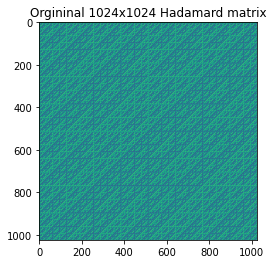

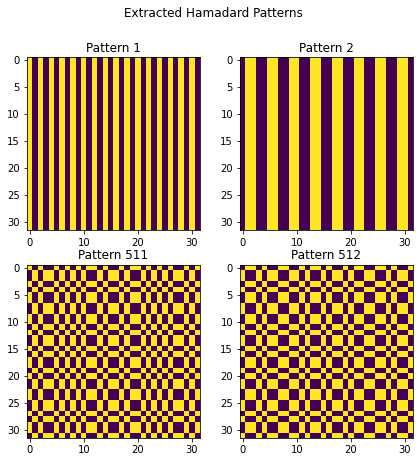

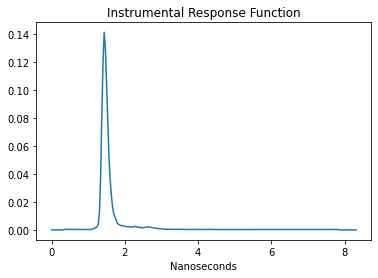

In [ ]:
plt.imshow(sp.linalg.hadamard(1024), cmap="viridis")
plt.title("Orgininal 1024x1024 Hadamard matrix")
plt.show()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(7,7))
ax1.imshow(hadamard[:,:,0])
ax1.set_title("Pattern 1")
ax2.imshow(hadamard[:,:,1])
ax2.set_title("Pattern 2")
ax3.imshow(hadamard[:,:,510])
ax3.set_title("Pattern 511")
ax4.imshow(hadamard[:,:,511])
ax4.set_title("Pattern 512")
fig.suptitle("Extracted Hamadard Patterns")
plt.show()

plt.plot(time, irf)
plt.title("Instrumental Response Function")
plt.xlabel("Nanoseconds")
plt.show()

We then define all the functions needed to generate a sample and the corresponding label.

In [ ]:
def resize(img):
    x,y,w,h = cv2.boundingRect(cv2.findNonZero(img))
    img_cut = img[x:x + w,y:y + h]
    img_resized = cv2.resize(img_cut, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    img_padded_h = np.concatenate((np.zeros((28,2)), img_resized, np.zeros((28,2))), axis=1)
    img_padded = np.concatenate((np.zeros((2,32)), img_padded_h, np.zeros((2,32))), axis=0)
    return img_padded

def binarize(img):
    max_img = img.max()
    img_bin = img >= 0.5*max_img
    return img_bin

def generate_intensity_lifetime(img):
    A = np.random.uniform(25, 1600, size=img.shape)
    tho = np.random.uniform(0.3, 1.5, size=img.shape)
    A_blu = cv2.GaussianBlur(A,(5,5),0)
    intensity = A_blu * img
    lifetime = tho * img
    return intensity, lifetime

def get_tpsf(intensity, lifetime):
    decay_curves = intensity[:,:,None]*np.exp(-times/(lifetime[:,:,None]+eps))
    tpsf = np.zeros((32, 32, 256))
    for x,y in np.ndindex(decay_curves[:,:, 0].shape):
        tpsf[x, y] = np.convolve(irf, decay_curves[x, y,:])[:256]
    return tpsf

def simulate_measures(tpsf):
    hadam_pos_tpsf = hadamard_pos[:,:,np.newaxis, :] * tpsf[:,:,:, np.newaxis]
    hadam_neg_tpsf = (hadamard_neg[:,:,np.newaxis, :] * tpsf[:,:,:, np.newaxis])

    measures = np.sum(hadam_pos_tpsf, axis=(0,1))
    measures_comp = np.sum(hadam_neg_tpsf, axis=(0,1))

    measures += np.random.poisson(measures)
    measures_comp += np.random.poisson(np.abs(measures_comp.copy()))

    final_measures = measures - measures_comp
    return final_measures

We can now test our generation process and explore each step.

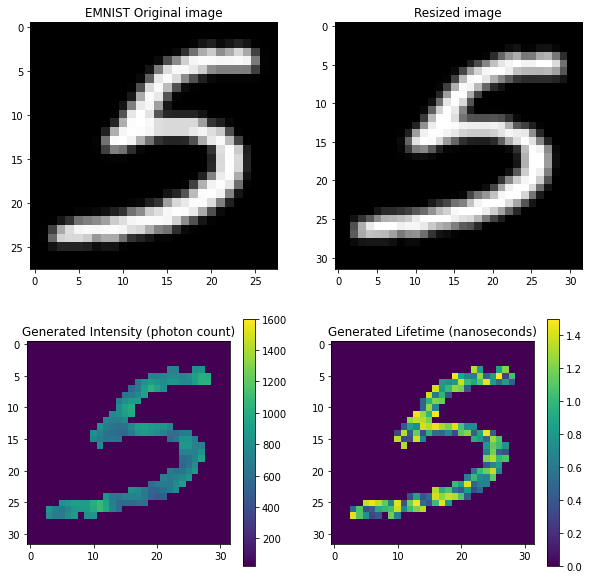

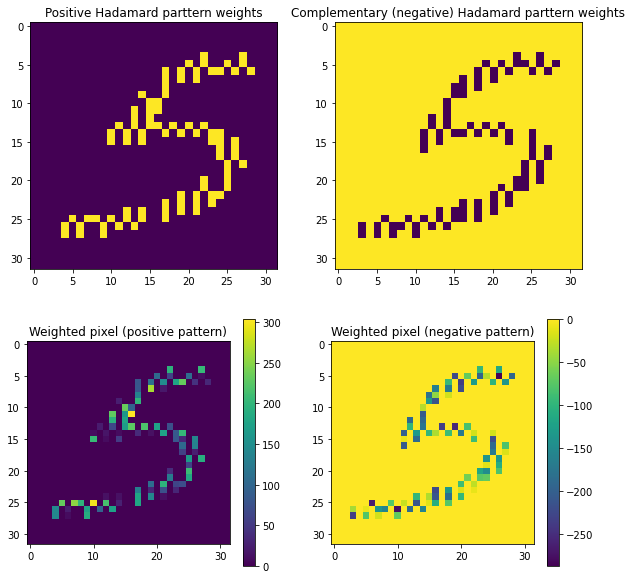

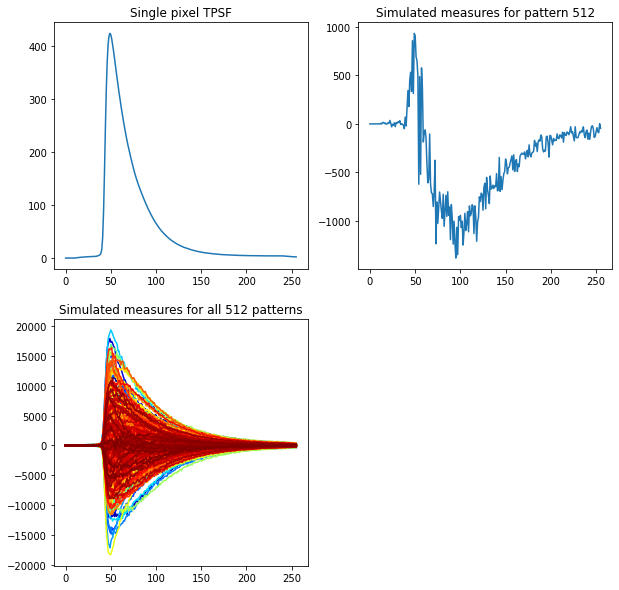

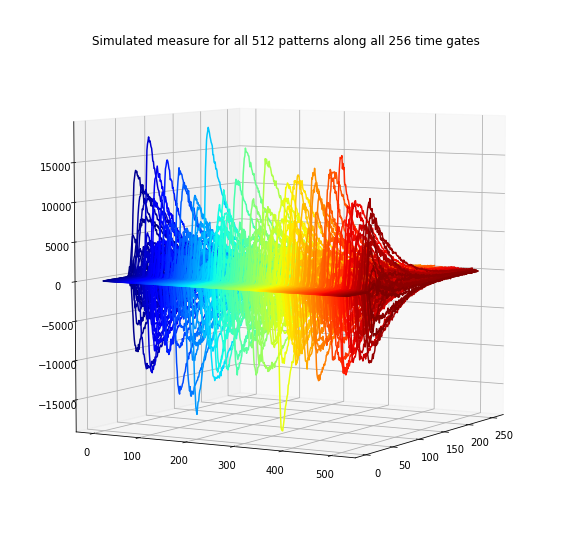

In [ ]:
sample = next(emnist_dataset_train.as_numpy_iterator())['image']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))

img = sample.squeeze().T
ax1.imshow(img, cmap='gray')
ax1.set_title("EMNIST Original image")

img_resized = resize(img)
ax2.imshow(img_resized, cmap='gray')
ax2.set_title("Resized image")

img_bin = binarize(img_resized)
intensity, lifetime = generate_intensity_lifetime(img_bin)

img_int = ax3.imshow(intensity, vmin=25, vmax=1600)
ax3.set_title("Generated Intensity (photon count)")
fig.colorbar(img_int, ax=ax3)

img_lifetime = ax4.imshow(lifetime)
ax4.set_title("Generated Lifetime (nanoseconds)")
fig.colorbar(img_lifetime, ax=ax4)
plt.show()

tpsf = get_tpsf(intensity, lifetime)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
ax1.imshow(hadamard_pos[:,:,100]*img_bin)
ax1.set_title("Positive Hadamard pattern weights")
ax2.imshow(-1 * hadamard_neg[:,:,100]*img_bin)
ax2.set_title("Complementary (negative) Hadamard pattern weights")
c3 = ax3.imshow(hadamard_pos[:,:,100]*tpsf[:,:,100])
ax3.set_title("Weighted pixel (positive pattern)")
fig.colorbar(c3, ax=ax3)
c4 = ax4.imshow(-(hadamard_neg[:,:,100]*tpsf[:,:,100]))
ax4.set_title("Weighted pixel (negative pattern)")
fig.colorbar(c4, ax=ax4)

plt.show()

final_measures = simulate_measures(tpsf)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
ax1.plot(tpsf[13, 13,:])
ax1.set_title("Single pixel TPSF")
ax2.plot(final_measures[:,511])
ax2.set_title("Simulated measures for pattern 512")
colors = plt.cm.jet(np.linspace(0,1,512))
for i in range(final_measures.shape[1]):
    ax3.plot(final_measures[:,i], color=colors[i])
ax3.set_title("Simulated measures for all 512 patterns")
ax4.axis("off")
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
  
colors = plt.cm.jet(np.linspace(0,1,512))
for i in range(final_measures.shape[1]):
    ax.plot(np.arange(256) , [i]*256 , final_measures[:,i], color=colors[i])

ax.invert_xaxis()
ax.view_init(6, 30)
ax.set_title("Simulated measure for all 512 patterns along all 256 time gates")
plt.show()

Now that we understand the process of generating one training sample, we can generate the whole dataset. The generation takes a long time so we provide an already generated dataset that can be downloaded (5 GB).

In [ ]:
![ $regenerate_dataset = False ] && gdown --id 1-3__xrBxg3U29PMdl61RwKhmvB4lwb6H && gdown --id 1v7tu0Wb_H5zmTdR_l5Yo7YEInFvmXDlv
if regenerate_dataset :
    for i, element in tqdm(enumerate(emnist_dataset_train.skip(k*5000).take(5000))):
        img = element['image'].numpy().squeeze().T
        img_resized = resize(img)
        img_bin = binarize(img_resized)
        intensity, lifetime = generate_intensity_lifetime(img_bin)

        tpsf = get_tpsf(intensity, lifetime)

        final_measures = simulate_measures(tpsf)

        dataset_array_train[i] = final_measures
        dataset_array_train_labels[i, 0] = intensity
        dataset_array_train_labels[i, 1] = lifetime

        np.save('dataset_train_input.npy', dataset_array_train)
        np.save('dataset_train_output.npy', dataset_array_train_labels)

Downloading...
From: https://drive.google.com/uc?id=1-3__xrBxg3U29PMdl61RwKhmvB4lwb6H
To: /content/dataset_train_output.npy
81.9MB [00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1v7tu0Wb_H5zmTdR_l5Yo7YEInFvmXDlv
To: /content/dataset_train_input.npy
5.24GB [01:40, 52.4MB/s]


###Model
Once the dataset is generated, we can talk about the architecture of this model.
The model is mostly based on convolutions. Since it is quite deep, it implements multiple architecture tricks to prevent vanishing gradient problem (batch normalisation, ResNet, ...).
The model can be split into 3 separate segments : 


*   **Shared Segment** : A segment used to extract useful feature from the input data
*   **Intensity Segment** : A segment used to reconstruct the intensity matrix from the abstract representation of the data provided by the Shared Segment.
*   **Lifetime Segment** : A segment used to reconstruct the lifetime matrix from the abstract representation of the data provided by the Shared Segment.

<figure>
    <img src="https://www.researchgate.net/publication/331548229/figure/fig1/AS:733442987814912@1551877843062/The-architecture-of-Net-FLICS-and-feature-maps-at-the-end-of-three-main-segments.png"
         >
    <figcaption>The architecture of Net-FLICS and feature maps at the end of three main segments visualized by t-SNE.</figcaption>
</figure>

#### Sub-blocks
The model is built with two sub-blocks invented for other models.
The first one is the **ReconBlock** . This block is inspired by the ReconNet architecture. The ReconNet is a CNN which goal is to reconstruct images from CS measurements. It is composed of many 1D and 2D convolution layers with ReLU activation. This network had better results than traditionnal reconstruction algorithms on lower measurement rates (0.1, 0.04 and 0.01).\
The second block used is the **ResBlock**. This block come from the ResNet model, a Deep CNN that was once state-of-the-art on the ImageNet dataset. The ResBlock use a skip connection in order to overcome the vanishing gradient problem so that the first layers of the model can learn correctly.

#### Shared Segment
The shared segment is simply a 1D convolution with 1024 filters and a kernel size of 3 (all convolutions in this model use a 'same' padding to avoid shape issues). We then use a batch normalization layer to reduce internal covariate shift which accelerate the training, followed by a ReLU activation. And last but not least we transpose the output. 

#### Intensity Segment
The Intensity Segment first reshapes the ouput of the Shared Segment to retreive a image format. It then call a ResBlock followed by a ReconBlock (which role was previously discussed).

#### Lifetime Segment
The Lifetime Segment is more complex. It is composed of 2 ResBlocks, 2 ReconBlocks and a 1D Convolution with 512 filters of kernel size 1.

In [ ]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Conv2D, ReLU, Reshape
import tensorflow as tf

class SharedSegment(tf.keras.Model):
    def __init__(self):
        super(SharedSegment, self).__init__()
        self.conv = Conv1D(1024, 3, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.transpose = tf.transpose

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.transpose(x, perm=[0,2,1])
        return x

class ResBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(ResBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, activation='relu', padding='same')
        self.conv2 = Conv2D(filters, kernel_size, padding='same')
        self.relu =  ReLU()

    def call(self, x_in):
        x = self.conv1(x_in)
        x = self.conv2(x)
        x += x_in
        x = self.relu(x)
        return x

class ReconBlock(tf.keras.Model):
    def __init__(self):
        super(ReconBlock, self).__init__()
        self.conv1 = Conv2D(64, 5, activation='relu', padding='same')
        self.conv2 = Conv2D(32, 1, activation='relu', padding='same')
        self.conv3 = Conv2D(1, 3, activation='relu', padding='same')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class IntensitySegment(tf.keras.Model):
    def __init__(self):
        super(IntensitySegment, self).__init__()
        self.reshape = Reshape((32, 32, 256))
        self.resblock = ResBlock(256, 3)
        self.reconblock = ReconBlock()

    def call(self, x):
        x = self.reshape(x)
        x = self.resblock(x)
        x = self.reconblock(x)
        return x

class LifetimeSegment(tf.keras.Model):
    def __init__(self):
        super(LifetimeSegment, self).__init__()
        self.conv = Conv1D(512, 1)
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.reshape = Reshape((32, 32, 512))
        self.resblock1 = ResBlock(512, 3)
        self.resblock2 = ResBlock(512, 3)
        self.reconblock1 = ReconBlock()
        self.reconblock2 = ReconBlock()

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.reshape(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.reconblock1(x)
        x = self.reconblock2(x)
        return x

class NetFLICS(tf.keras.Model):
    def __init__(self, dim):
        super(NetFLICS, self).__init__()
        self.dim = dim
        self.shared = SharedSegment()
        self.intensity = IntensitySegment()
        self.lifetime = LifetimeSegment()

    def call(self, x):
        x_shared = self.shared(x)
        x_int = self.intensity(x_shared)
        x_lifetime = self.lifetime(x_shared)
        output = tf.concat([x_int, x_lifetime], axis=3)
        return output

## Training
For the training, there are multiple things that the authors needed to define. \
First the loss. They chose to add the Mean Square Error between the lifetimes matrices and the intensity matrices. However as the lifetimes are clearly smaller than the intensities (pico scale instead of unit scale), they weighted the lifetime MSE by $10^5$.\
They also defined an optimiszer : RMSProp and an early stopping condition.\
In order to have a better learning, they chose to devide the learning rate by 2 every 10 epochs.\
The main missing information was the batch size. To obtain it, we did multiple tests and we obtain best results with a batch size of 124.\
The authors managed to train their model on 32,000 and use 8000 samples for validation. On our side, we had some limitations that prevented us from using that amount of samples (to use a GPU for training we worked on Kaggle which has a time limit for running a notebook, and only 16 GB of RAM). We only managed to train our model on 4500 samples and validate on 500 samples.\
In total there are 13,565,635 trainable parameters and 3,072 non trainable parameters.

In [ ]:
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

dataset_array_train = np.load('dataset_train_input.npy')
dataset_array_train_labels = np.load('dataset_train_output.npy')
dataset_array_train_labels = np.transpose(dataset_array_train_labels, axes=[0,2,3,1])

mse = MeanSquaredError()
mae = MeanAbsoluteError()

netflics = NetFLICS(dataset_array_train[0].shape)

def loss_fn(y_pred, y_true):
    mse_int = mse(y_pred[:,:,:,0], y_true[:,:,:,0])
    mse_lifetime = mse(y_pred[:,:,:,1], y_true[:,:,:,1])
    return mse_int + 1e8 * mse_lifetime

def mae_int(y_pred, y_true):
    mae_int = mae(y_pred[:,:,:,0], y_true[:,:,:,0])
    return mae_int

def mae_lifetime(y_pred, y_true):
    mae_lifetime = mae(y_pred[:,:,:,1], y_true[:,:,:,1])
    return mae_lifetime


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 0.001 / (2 * (epoch//10))
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
netflics.compile(optimizer='rmsprop', loss=loss_fn, metrics=[mae_int, mae_lifetime])
history = netflics.fit(dataset_array_train, dataset_array_train_labels, batch_size=124, epochs=50, validation_split=0.1, callbacks=[callback])

Epoch 1/50
37/37 [==============================] - 89s 1s/step - loss: 368793879298902.0000 - mae_int: 216.4161 - mae_lifetime: 529.5990 - val_loss: 16022533.0000 - val_mae_int: 301.3762 - val_mae_lifetime: 0.1993
Epoch 2/50
37/37 [==============================] - 34s 921ms/step - loss: 15459764.7105 - mae_int: 239.1125 - mae_lifetime: 0.2199 - val_loss: 14255767.0000 - val_mae_int: 236.1409 - val_mae_lifetime: 0.2685
Epoch 3/50
37/37 [==============================] - 35s 952ms/step - loss: 14179203.0526 - mae_int: 233.4626 - mae_lifetime: 0.2659 - val_loss: 13682420.0000 - val_mae_int: 252.9164 - val_mae_lifetime: 0.2608
Epoch 4/50
37/37 [==============================] - 36s 967ms/step - loss: 13743266.3158 - mae_int: 225.1015 - mae_lifetime: 0.2548 - val_loss: 13086725.0000 - val_mae_int: 233.6702 - val_mae_lifetime: 0.2471
Epoch 5/50
37/37 [==============================] - 36s 973ms/step - loss: 13827645.3684 - mae_int: 216.9389 - mae_lifetime: 0.2328 - val_loss: 12841802.0000 

## Results
To assess the performance of the model, the authors used the Mean Absolute Error separately for the lifetime and the intensity matrices.\
They obtained good results for both lifetime and intensity. At the end of the training they had a lifetime MAE of 0.02 and an intensity MAE of 9.48.\
In our experiments the model reached lifetime MAE of 0.10 and an intensity MAE of 70.\
There are various factors that can explain this gap. First of all the number of sample for the training. Secondly, the training results varied a lot between each run, and also between the epochs. They used a checkpoint to retreive the best model, which explain the optimality of their model. The authors also used data augmentation (consisting in rotating the images, stiching them together, ...) which leads to a more robus model.

<figure>
    <img src="https://www.researchgate.net/publication/331548229/figure/fig2/AS:733442987814914@1551877843153/Net-FLICS-MAE-training-curves-and-final-MAE-distributions-for-800-simulated-samples-a.png"
         >
    <figcaption>Net-FLICS MAE training curves and final MAE distributions for 800 simulated samples.</figcaption>
</figure>


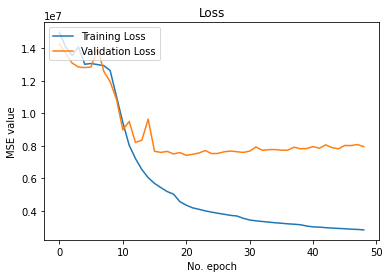

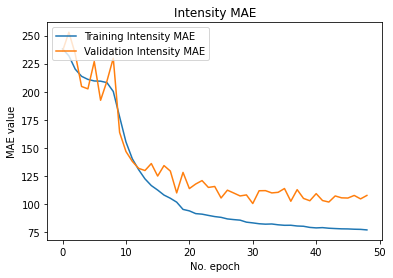

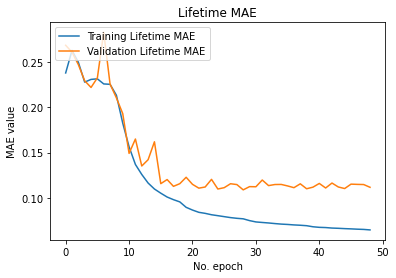

In [ ]:
plt.plot(history.history['loss'][1:], label='Training Loss')
plt.plot(history.history['val_loss'][1:], label='Validation Loss')
plt.title('Loss')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['mae_int'][1:], label='Training Intensity MAE')
plt.plot(history.history['val_mae_int'][1:], label='Validation Intensity MAE')
plt.title('Intensity MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['mae_lifetime'][1:], label='Training Lifetime MAE')
plt.plot(history.history['val_mae_lifetime'][1:], label='Validation Lifetime MAE')
plt.title('Lifetime MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


## Comparison
The authors mainly compared their method to the method described in the MFLI section, known as TVRecon method. This method used the TVAL3 solver which seems unavailable on the website of its creators, so we were not able to replicate their comparison.\
However, the authors managed to use the TVRecon technique on the generated dataset and they found worse results : intensity MAE 13.80, lifetime MAE 0.05.\
They also managed to test these methods on real data and once again found that their Deep Learning approach beat the original method.


<figure>
    <img src="https://www.researchgate.net/publication/331548229/figure/tbl1/AS:733442987786240@1551877843182/MAE-and-SSIM-of-intensity-and-lifetime-reconstruction-results-on-800-simulated-samples.png"
         >
    <figcaption>MAE and SSIM of intensity and lifetime reconstruction results on 800 simulated samples.</figcaption>
</figure>

## Conclusion
Even if it is only the first model designed to solve this kind of problems, Net-Flics managed to beat the state-of-the-art method by a large margin. This is really promising. The development of Deep Learning for this kind of applications could lead to save a lot of time, but more importantly, to have better results for the researcher's experiments.